<a href="https://colab.research.google.com/github/aryan-at-ul/graph_from_patches/blob/main/thesis_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
import time
import traceback
import pickle
import torch
from torchvision import datasets, transforms
import cv2
from skimage.segmentation import slic, mark_boundaries
from skimage.future import graph
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [ ]:


# Define the transformation to apply on the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the training data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Load the test data
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Example of accessing a single image and its label
image, label = train_data[0]

print('Label: ', label)
print('Image size: ', image.shape)

# If you want to visualize the image
import matplotlib.pyplot as plt

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('Label: '+str(label))
plt.show()


In [4]:
def make_superpixel_graph(image,label,n_segment = 300):

    superpixels = slic(image, n_segments= 100)
    rag = graph.rag_mean_color(image, superpixels, mode='distance')

    centroids = {region.label: region.centroid for region in regionprops(superpixels)}

    # Calculate the average depth of each superpixel
    superpixel_depths = np.zeros(np.max(superpixels) + 1)
    superpixel_counts = np.zeros_like(superpixel_depths)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            superpixel_depths[superpixels[x, y]] += image[x, y]
            superpixel_counts[superpixels[x, y]] += 1
    superpixel_depths /= np.maximum(superpixel_counts, 1)

    # Reconstructing graph
    for edge in rag.edges():
        current_label, neighbor_label = edge
        avg_intensity = (superpixel_depths[current_label] + superpixel_depths[neighbor_label]) / 2
        rag.edges[current_label, neighbor_label]['weight'] = avg_intensity
    return rag, label


In [6]:

def graph_dataset_gen(dataset, typ):
    datalist = []
    k = 0
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(make_superpixel_graph, one_data[0].squeeze().numpy(), one_data[1])  for  i,one_data in enumerate(dataset)]
        for future in concurrent.futures.as_completed(futures):
            try:
                k += 1
                g, label = future.result()
                datalist.append([g,label])
                if k % 1000 == 0:
                    print(f"done {k}")
            except Exception as exc:
                print(f'generated an exception: {exc} for seg {k}')
                print(traceback.format_exc())
    # for one_data  in dataset:
    #     k += 1
    #     image, label = one_data
    #     img_graph = make_superpixel_graph(image.squeeze().numpy(), label, 300)
    #     datalist.append((img_graph,label))
    #     if k % 100 == 0:
    #         print(f"transformed {k} images")
    return datalist


In [7]:
train_datalist = graph_dataset_gen(train_data, 1)

done 1000
done 2000
done 3000
done 4000
done 5000
done 6000
done 7000
done 8000
done 9000
done 10000
done 11000
done 12000
done 13000
done 14000
done 15000
done 16000
done 17000
done 18000
done 19000
done 20000
done 21000
done 22000
done 23000
done 24000
done 25000
done 26000
done 27000
done 28000
done 29000
done 30000
done 31000
done 32000
done 33000
done 34000
done 35000
done 36000
done 37000
done 38000
done 39000
done 40000
done 41000
done 42000
done 43000
done 44000
done 45000
done 46000
done 47000
done 48000
done 49000
done 50000
done 51000
done 52000
done 53000
done 54000
done 55000
done 56000
done 57000
done 58000
done 59000
done 60000


In [1]:
with open('train_datalist.pkl','wb') as f:
    pickle.dump(train_datalist,f)

NameError: ignored

In [ ]:
test_datalist = graph_dataset_gen(test_data, 0)
with open('test_datalist.pkl','wb') as f:
    pickle.dump(test_datalist,f)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# with open('/content/drive/MyDrive/pickle/train_datalist.pkl','rb') as f:
#     train_datalist = pickle.load(f)


# with open('/content/drive/MyDrive/pickle/test_datalist.pkl','rb') as f:
#     test_datalist = pickle.load(f)

In [ ]:
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt

# Load the image
image = Image.open("/content/8mnist.jpeg").convert("L")  # Convert to grayscale
pixel_matrix = image.load()

# Create a graph
G = nx.Graph()

# Iterate through the pixels
width, height = image.size
for x in range(width):
    for y in range(height):
        # Add nodes to the graph
        pixel_value = pixel_matrix[x, y]
        G.add_node((x, y), value=pixel_value)

        # Add edges to neighboring nodes
        if x > 0:
            G.add_edge((x, y), (x - 1, y), weight=abs(pixel_value - pixel_matrix[x - 1, y]))
        if x < width - 1:
            G.add_edge((x, y), (x + 1, y), weight=abs(pixel_value - pixel_matrix[x + 1, y]))
        if y > 0:
            G.add_edge((x, y), (x, y - 1), weight=abs(pixel_value - pixel_matrix[x, y - 1]))
        if y < height - 1:
            G.add_edge((x, y), (x, y + 1), weight=abs(pixel_value - pixel_matrix[x, y + 1]))

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color="lightblue", node_size=10, with_labels=False)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.axis("off")
plt.show()


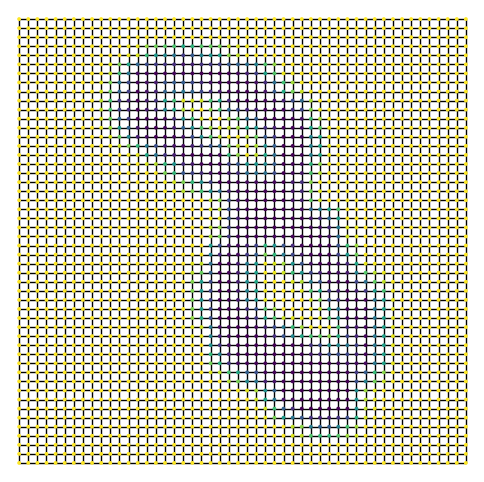

In [9]:
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt

# Load and resize the image
image = Image.open("/content/8mnist.jpeg").convert("L")  # Convert to grayscale
image = image.resize((50, 50))
pixel_matrix = image.load()

# Create a graph
G = nx.Graph()

# Iterate through the pixels
width, height = image.size
for x in range(width):
    for y in range(height):
        # Add nodes to the graph
        pixel_value = pixel_matrix[x, y]
        G.add_node((x, y), value=pixel_value)

        # Add edges to neighboring nodes
        if x > 0:
            G.add_edge((x, y), (x - 1, y), weight=abs(pixel_value - pixel_matrix[x - 1, y]))
        if x < width - 1:
            G.add_edge((x, y), (x + 1, y), weight=abs(pixel_value - pixel_matrix[x + 1, y]))
        if y > 0:
            G.add_edge((x, y), (x, y - 1), weight=abs(pixel_value - pixel_matrix[x, y - 1]))
        if y < height - 1:
            G.add_edge((x, y), (x, y + 1), weight=abs(pixel_value - pixel_matrix[x, y + 1]))

# Plot the graph with node and edge colors
node_colors = [G.nodes[node]["value"] for node in G.nodes()]
# edge_colors = [G.edges[edge]["weight"] for edge in G.edges()]

# Create a custom layout placing nodes in their positions
pos = {node: node for node in G.nodes()}

# Scale the figure size to accommodate all nodes
fig, ax = plt.subplots(figsize=(6, 6))
nx.draw_networkx(G, pos, node_color=node_colors, edge_color="black", node_size=3, with_labels=False, ax=ax)
plt.xlim(-1, width)
plt.ylim(-1, height)
plt.axis("off")
plt.show()


In [ ]:
!pip install ripser
!pip install persim

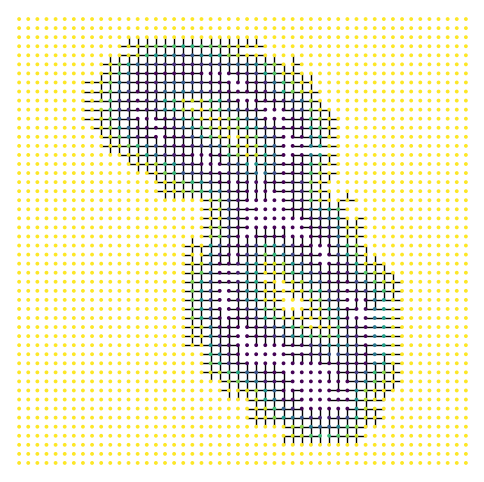

In [17]:
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt

# Load and resize the image
image = Image.open("/content/8mnist.jpeg").convert("L")  # Convert to grayscale
image = image.resize((50, 50))
pixel_matrix = image.load()

# Create a graph
G = nx.Graph()

# Define weight threshold
weight_threshold = 1

# Iterate through the pixels
width, height = image.size
for x in range(width):
    for y in range(height):
        # Add nodes to the graph
        pixel_value = pixel_matrix[x, y]
        G.add_node((x, y), value=pixel_value)

        # Add edges to neighboring nodes only if weight is larger than threshold
        if x > 0:
            weight_x_minus_1 = abs(pixel_value - pixel_matrix[x - 1, y])
            if weight_x_minus_1 > weight_threshold:
                G.add_edge((x, y), (x - 1, y), weight=weight_x_minus_1)
        if x < width - 1:
            weight_x_plus_1 = abs(pixel_value - pixel_matrix[x + 1, y])
            if weight_x_plus_1 > weight_threshold:
                G.add_edge((x, y), (x + 1, y), weight=weight_x_plus_1)
        if y > 0:
            weight_y_minus_1 = abs(pixel_value - pixel_matrix[x, y - 1])
            if weight_y_minus_1 > weight_threshold:
                G.add_edge((x, y), (x, y - 1), weight=weight_y_minus_1)
        if y < height - 1:
            weight_y_plus_1 = abs(pixel_value - pixel_matrix[x, y + 1])
            if weight_y_plus_1 > weight_threshold:
                G.add_edge((x, y), (x, y + 1), weight=weight_y_plus_1)

# Plot the graph with node and edge colors
node_colors = [G.nodes[node]["value"] for node in G.nodes()]

# Create a custom layout placing nodes in their positions
pos = {node: node for node in G.nodes()}

# Scale the figure size to accommodate all nodes
fig, ax = plt.subplots(figsize=(6, 6))
nx.draw_networkx(G, pos, node_color=node_colors, edge_color="black", node_size=3, with_labels=False, ax=ax)
plt.xlim(-1, width)
plt.ylim(-1, height)
plt.axis("off")
plt.show()


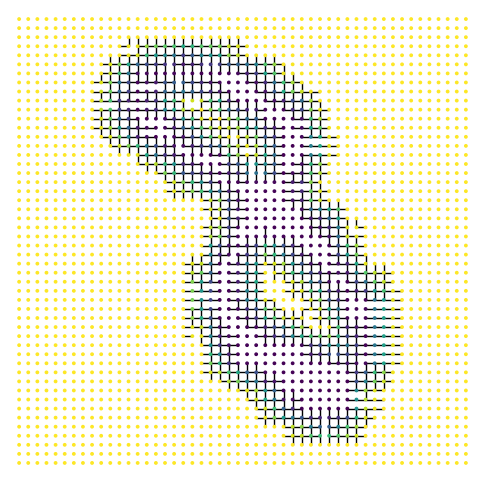

In [1]:
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Load and resize the image
image = Image.open("/content/8mnist.jpeg").convert("L")  # Convert to grayscale
image = image.resize((50, 50))
pixel_matrix = image.load()

# Create a graph
G = nx.Graph()

# Define weight threshold
weight_threshold = 5

# Keep track of the isolated nodes
isolated_nodes = []

# Iterate through the pixels
width, height = image.size
for x in range(width):
    for y in range(height):
        # Add nodes to the graph
        pixel_value = pixel_matrix[x, y]
        G.add_node((x, y), value=pixel_value)

        # Add edges to neighboring nodes only if weight is larger than threshold
        # If not, add the node to the list of isolated nodes
        isolated = True
        if x > 0:
            weight_x_minus_1 = abs(pixel_value - pixel_matrix[x - 1, y])
            if weight_x_minus_1 > weight_threshold:
                G.add_edge((x, y), (x - 1, y), weight=weight_x_minus_1)
                isolated = False
        if x < width - 1:
            weight_x_plus_1 = abs(pixel_value - pixel_matrix[x + 1, y])
            if weight_x_plus_1 > weight_threshold:
                G.add_edge((x, y), (x + 1, y), weight=weight_x_plus_1)
                isolated = False
        if y > 0:
            weight_y_minus_1 = abs(pixel_value - pixel_matrix[x, y - 1])
            if weight_y_minus_1 > weight_threshold:
                G.add_edge((x, y), (x, y - 1), weight=weight_y_minus_1)
                isolated = False
        if y < height - 1:
            weight_y_plus_1 = abs(pixel_value - pixel_matrix[x, y + 1])
            if weight_y_plus_1 > weight_threshold:
                G.add_edge((x, y), (x, y + 1), weight=weight_y_plus_1)
                isolated = False
        if isolated:
            isolated_nodes.append((x, y))

# Apply kNN to the isolated nodes
isolated_pixels = np.array([pixel_matrix[node] for node in isolated_nodes]).reshape(-1, 1)
knn = NearestNeighbors(n_neighbors=3).fit(isolated_pixels)
distances, indices = knn.kneighbors(isolated_pixels)

for index, (distance, idx) in enumerate(zip(distances, indices)):
    if distance[0] > 0:  # ignore the self node
        G.add_edge(isolated_nodes[index], isolated_nodes[idx[0]], weight=distance[0])

# Plot the graph with node and edge colors
node_colors = [G.nodes[node]["value"] for node in G.nodes()]

# Create a custom layout placing nodes in their positions
pos = {node: node for node in G.nodes()}

# Scale the figure size to accommodate all nodes
fig, ax = plt.subplots(figsize=(6, 6))
nx.draw_networkx(G, pos, node_color=node_colors, edge_color="black", node_size=3, with_labels=False, ax=ax)
plt.xlim(-1, width)
plt.ylim(-1, height)
plt.axis("off")
plt.show()


In [18]:
!pip install pip install gudhi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.1 MB/s eta 0:00:00


In [3]:
import gudhi as gd
import gudhi.representations


In [ ]:
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np
import gudhi as gd
import gudhi.representations

# Load and resize the image
image = Image.open("/content/8mnist.jpeg").convert("L")  # Convert to grayscale
image = image.resize((50, 50))
pixel_matrix = image.load()

# Create a graph
G = nx.Graph()

# Define weight threshold
weight_threshold = 5

# Keep track of the isolated nodes
isolated_nodes = []

# Iterate through the pixels
width, height = image.size
for x in range(width):
    for y in range(height):
        # Add nodes to the graph
        pixel_value = pixel_matrix[x, y]
        G.add_node((x, y), value=pixel_value)

        # Add edges to neighboring nodes only if weight is larger than threshold
        # If not, add the node to the list of isolated nodes
        isolated = True
        if x > 0:
            weight_x_minus_1 = abs(pixel_value - pixel_matrix[x - 1, y])
            if weight_x_minus_1 > weight_threshold:
                G.add_edge((x, y), (x - 1, y), weight=weight_x_minus_1)
                isolated = False
        if x < width - 1:
            weight_x_plus_1 = abs(pixel_value - pixel_matrix[x + 1, y])
            if weight_x_plus_1 > weight_threshold:
                G.add_edge((x, y), (x + 1, y), weight=weight_x_plus_1)
                isolated = False
        if y > 0:
            weight_y_minus_1 = abs(pixel_value - pixel_matrix[x, y - 1])
            if weight_y_minus_1 > weight_threshold:
                G.add_edge((x, y), (x, y - 1), weight=weight_y_minus_1)
                isolated = False
        if y < height - 1:
            weight_y_plus_1 = abs(pixel_value - pixel_matrix[x, y + 1])
            if weight_y_plus_1 > weight_threshold:
                G.add_edge((x, y), (x, y + 1), weight=weight_y_plus_1)
                isolated = False
        if isolated:
            isolated_nodes.append((x, y))

# Apply kNN to the isolated nodes
isolated_pixels = np.array([pixel_matrix[node] for node in isolated_nodes]).reshape(-1, 1)
knn = NearestNeighbors(n_neighbors=1).fit(isolated_pixels)
distances, indices = knn.kneighbors(isolated_pixels)

for index, (distance, idx) in enumerate(zip(distances, indices)):
    if distance[0] > 0:  # ignore the self node
        G.add_edge(isolated_nodes[index], isolated_nodes[idx[0]], weight=distance[0])

# Create the Rips complex
rips_complex = gd.RipsComplex(distance_matrix=nx.to_numpy_array(G), max_edge_length=255)

# Create the simplex tree
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

# Compute persistence
diag = simplex_tree.persistence(min_persistence=0.01)

# Create a persistence image transformer
pi = gudhi.representations.PersistenceImage()

# Fit and transform the persistence diagram
img = pi.fit_transform([diag])

# Now `img` is a vectorized representation of the persistent homology
print(img)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 85.3MB/s]


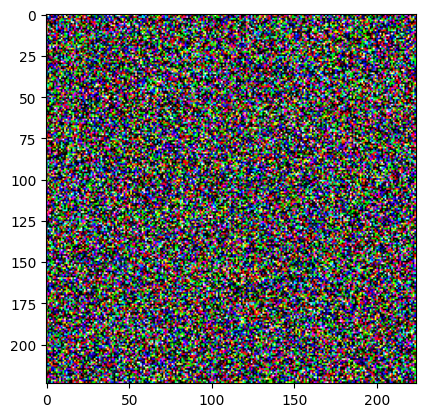

tensor([[-7.6402e-02,  3.2551e-01,  1.4901e+00, -9.2804e-01,  8.3130e-01,
         -5.8202e-01,  1.0728e-01, -5.6753e-01, -4.3082e-01, -2.8188e+00,
         -2.9615e+00,  1.8764e+00, -1.7450e+00, -1.1878e+00, -7.5976e-01,
         -3.0352e+00, -2.1307e+00,  1.8642e+00,  2.6123e+00, -7.7181e-01,
         -2.6111e+00, -1.1655e+00, -2.1219e+00, -1.9773e+00, -1.8513e-01,
         -3.6472e+00, -2.6178e+00, -3.7981e+00, -3.1490e+00, -1.1111e+00,
         -3.0106e-01, -1.1579e-01, -4.1780e+00,  8.4046e-02,  6.5870e-01,
         -9.8090e-01, -1.4410e+00, -4.3544e+00, -2.3902e+00,  1.4532e-01,
         -1.4323e+00, -3.2309e+00, -7.7589e-01, -2.7094e+00, -1.6313e-02,
         -2.4727e+00,  4.1803e-01, -2.8003e+00,  2.3972e+00, -1.8148e+00,
         -7.8531e-01,  1.1621e+00, -6.0343e-01, -1.1499e+00, -8.2479e-01,
          3.5345e-01,  6.4630e-01, -2.6448e-01, -1.9634e+00, -9.3507e-01,
          1.8074e+00,  1.1504e+00, -3.8993e-01, -3.0027e+00, -1.9276e+00,
         -2.6569e-01, -3.4285e+00, -7.

In [1]:
# Necessary imports
import torch
from torchvision import models, transforms, utils
from PIL import Image
import matplotlib.pyplot as plt

# Load pretrained DenseNet model
model = models.densenet121(pretrained=True)
model.eval()  # Set model to eval mode

# Load a sample image from TorchVision
sample_image = utils.make_grid(torch.randn((1, 3, 224, 224)))  # Creating a random image of shape (1, 3, 224, 224)

# Display the image
plt.imshow(sample_image.permute(1, 2, 0))  # Reorder dimensions to match what Matplotlib expects
plt.show()

# Normalize the image
preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the image
input_tensor = preprocess(sample_image)
input_batch = input_tensor.unsqueeze(0)  # Add an extra dimension for batch size

# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input to the device
input_batch = input_batch.to(device)

# Move the model to the device
model = model.to(device)

# Perform forward pass
with torch.no_grad():
    output = model(input_batch)

# Print the output
print(output)


In [3]:
# Convert output probabilities to predicted class
import numpy as np
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

print(preds)

490


In [15]:
!pip install torchray captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.5 MB/s eta 0:00:00


In [12]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from torchray.attribution.grad_cam import grad_cam
from torchray.benchmark import plot_example
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Model
model = models.densenet121(pretrained=True)
model = model.eval()

# Image transform function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Use a URL that points directly to an image
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Red_nebula.jpg/800px-Red_nebula.jpg'

# Load image from the URL
response = requests.get(url)
img = Image.open("/content/dest.png")

# Apply the transformations
input_image = transform(img)
# input_image = input_image.unsqueeze(0)
input_image = input_image.unsqueeze(0).clone()

# Get the saliency map using Grad-CAM
# saliency = grad_cam(model, input_image, saliency_layer='features.norm5')
saliency = grad_cam(model, input_image, target=207, saliency_layer='features.norm5')


# Plot
plt.figure(figsize=(10, 5))
plot_example(input_image[0], saliency, 'Grad-CAM')
plt.show()


RuntimeError: ignored

(256, 256, 7)
(256, 256)


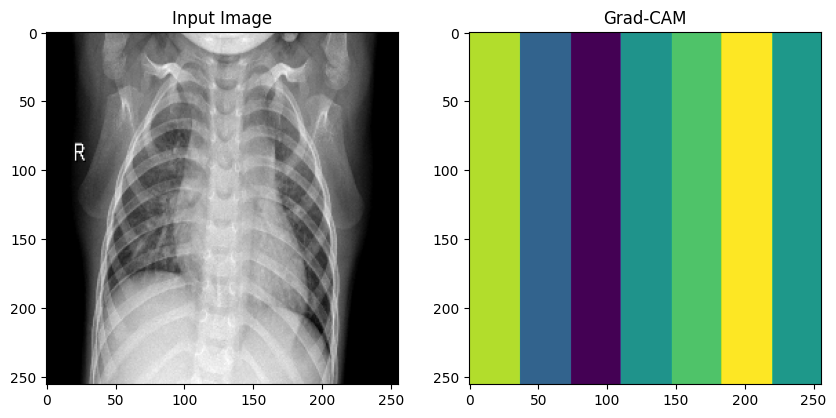

In [24]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from captum.attr import LayerGradCam
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import cv2
import numpy as np

# Model
model = models.densenet121(pretrained=True)
model = model.eval()

# Image transform function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Open local image file
img = Image.open("/content/dest.png")
img_orig = img.copy() # Copy for displaying later

# Apply the transformations
input_image = transform(img)
input_image = input_image.unsqueeze(0).clone()

# Specify the target class (207 for Golden Retriever, adjust as necessary)
target_class = 492

# Init GradCAM and compute saliency map
gradcam = LayerGradCam(model, model.features.norm5)
saliency = gradcam.attribute(input_image, target_class)

# Resize saliency map
saliency = saliency[0].detach().numpy()
saliency = cv2.resize(saliency, (img_orig.size), interpolation=cv2.INTER_NEAREST)


print(saliency.shape)
# Squeeze unnecessary dimensions and take maximum across channels
saliency = np.squeeze(saliency)
if saliency.ndim == 3:
    saliency = np.amax(saliency, axis=2)

print(saliency.shape)
# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(saliency)#, cmap='hot')
plt.show()


In [ ]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

In [ ]:
import numpy as np
from skimage import io, color
from skimage.feature import greycomatrix, greycoprops
# skimage.feature.graycomatrix,graycoprops
import torch
from torch_geometric.data import Data
from torchvision import datasets, transforms

# Transform to convert the images to grayscale
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Download the CIFAR10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

def calculate_features(image):
    # Convert the image to uint8
    image = (image * 255).astype(np.uint8)

    # Calculate the GLCM of the image
    glcm = greycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    # Calculate the Haralick features
    energy = greycoprops(glcm, 'energy')[0, 0]
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    entropy = -np.sum(glcm*np.log2(glcm + np.finfo(float).eps))

    return [energy, contrast, correlation, homogeneity, entropy]

def image_to_graph(image):
    h, w = image.shape

    # Create nodes
    nodes = [calculate_features(image[i:i+5, j:j+5]) for i in range(0, h, 5) for j in range(0, w, 5)]

    # Create edges
    edges = []
    for i in range(h//5):
        for j in range(w//5):
            # connect node (i, j) with its neighbors
            if i+1 < h//5:
                edges.append((i*(w//5)+j, (i+1)*(w//5)+j))  # down
            if j+1 < w//5:
                edges.append((i*(w//5)+j, i*(w//5)+j+1))  # right

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(nodes, dtype=torch.float)

    return Data(x=x, edge_index=edge_index)

# Example usage:
image, _ = dataset[0]  # Get the first image from the dataset
image = image.numpy().squeeze()  # Convert the image to a numpy array
graph = image_to_graph(image)
print(graph)

In [30]:
print(graph)

Data(x=[49, 5], edge_index=[2, 60])


Files already downloaded and verified


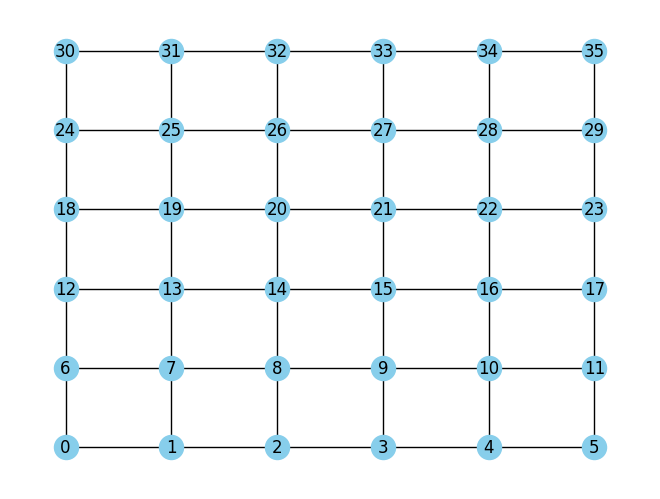

In [55]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from skimage import io, color
from skimage.feature import greycomatrix, greycoprops
import torch
from torch_geometric.data import Data
from torchvision import datasets, transforms

# Transform to convert the images to grayscale
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Download the CIFAR10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

def calculate_features(image):
    # Convert the image to uint8
    image = (image * 255).astype(np.uint8)

    # Calculate the GLCM of the image
    glcm = greycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    # Calculate the Haralick features
    energy = greycoprops(glcm, 'energy')[0, 0]
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    entropy = -np.sum(glcm*np.log2(glcm + np.finfo(float).eps))

    return [energy, contrast, correlation, homogeneity, entropy]

# def image_to_graph(image):
#     h, w = image.shape

#     # Create nodes
#     nodes = [calculate_features(image[i:i+5, j:j+5]) for i in range(0, h, 5) for j in range(0, w, 5)]

#     # Create edges
#     edges = []
#     for i in range(h//5):
#         for j in range(w//5):
#             # connect node (i, j) with its neighbors
#             if i+1 < h//5:
#                 edges.append((i*(w//5)+j, (i+1)*(w//5)+j))  # down
#             if j+1 < w//5:
#                 edges.append((i*(w//5)+j, i*(w//5)+j+1))  # right

#     edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
#     x = torch.tensor(nodes, dtype=torch.float)

#     return Data(x=x, edge_index=edge_index)
def image_to_graph(image):
    # Calculate the number of patches along height and width
    h, w = image.shape
    h_patches = h // 5
    w_patches = w // 5

    # Create nodes
    nodes = [calculate_features(image[i*5:(i+1)*5, j*5:(j+1)*5]) for i in range(h_patches) for j in range(w_patches)]

    # Create edges
    edges = []
    edge_weights = []
    for i in range(h_patches):
        for j in range(w_patches):
            # Node index
            node_idx = i * w_patches + j

            # Neighbors' indices and existence flags
            right_neighbor = node_idx+1 if (j+1) < w_patches else None
            down_neighbor = node_idx+w_patches if (i+1) < h_patches else None

            if down_neighbor is not None:
                edges.append((node_idx, down_neighbor))  # down
                edge_weights.append(abs(np.mean(image[i*5:(i+1)*5, j*5:(j+1)*5]) - np.mean(image[(i+1)*5:(i+2)*5, j*5:(j+1)*5])))

            if right_neighbor is not None:
                edges.append((node_idx, right_neighbor))  # right
                edge_weights.append(abs(np.mean(image[i*5:(i+1)*5, j*5:(j+1)*5]) - np.mean(image[i*5:(i+1)*5, (j+1)*5:(j+2)*5])))

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(nodes, dtype=torch.float)
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


def image_to_graph2(image):
    # Calculate the number of patches along height and width
    h, w = image.shape
    h_patches = h // 5
    w_patches = w // 5

    # Create nodes, now each node will store the actual image patch
    nodes = [image[i*5:(i+1)*5, j*5:(j+1)*5].flatten() for i in range(h_patches) for j in range(w_patches)]

    # Create edges
    edges = []
    edge_weights = []
    for i in range(h_patches):
        for j in range(w_patches):
            # Node index
            node_idx = i * w_patches + j

            # Neighbors' indices and existence flags
            right_neighbor = node_idx+1 if (j+1) < w_patches else None
            down_neighbor = node_idx+w_patches if (i+1) < h_patches else None

            if down_neighbor is not None:
                edges.append((node_idx, down_neighbor))  # down
                edge_weights.append(abs(np.mean(image[i*5:(i+1)*5, j*5:(j+1)*5]) - np.mean(image[(i+1)*5:(i+2)*5, j*5:(j+1)*5])))

            if right_neighbor is not None:
                edges.append((node_idx, right_neighbor))  # right
                edge_weights.append(abs(np.mean(image[i*5:(i+1)*5, j*5:(j+1)*5]) - np.mean(image[i*5:(i+1)*5, (j+1)*5:(j+2)*5])))

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.stack([torch.tensor(node, dtype=torch.float) for node in nodes]) # Convert nodes to tensor
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)




# Example usage:
image, _ = dataset[2]  # Get the first image from the dataset
image = image.numpy().squeeze()  # Convert the image to a numpy array
graph = image_to_graph2(image)

# Create a NetworkX graph for visualization
G = nx.Graph()

# Add nodes
for i, node_feature in enumerate(graph.x.numpy()):
    G.add_node(i)

# Add edges
for edge in graph.edge_index.t().numpy():
    G.add_edge(edge[0], edge[1])

# Create positions for each node based on their original locations
# h, w = (32//5, 32//5)  # adjust this based on your image size
# positions = {i: ((i % w)*5, (i // h)*5) for i in range(h*w)}
# number of nodes
n_nodes = len(graph.x)

# dimensions of the grid
h, w = int(np.ceil(np.sqrt(n_nodes))), int(np.ceil(np.sqrt(n_nodes)))

positions = {i: ((i % w)*5, (i // h)*5) for i in range(n_nodes)}


# Draw the graph
nx.draw(G, positions, with_labels=True, node_color='skyblue')

# Show the plot
plt.show()


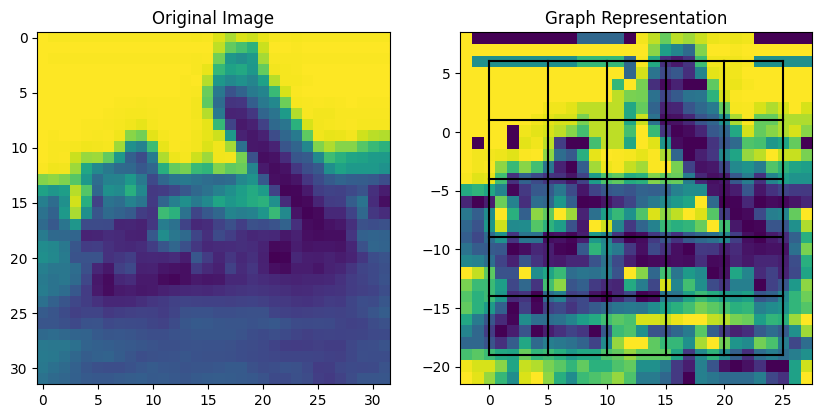

In [56]:
# def plot_graph(graph, image):
#     # positions = get_node_positions(graph)
#     h, w = image.shape
#     h_patches = h // 5
#     w_patches = w // 5

#     n_nodes = len(graph.x)

# # dimensions of the grid
    # h, w = int(np.ceil(np.sqrt(n_nodes))), int(np.ceil(np.sqrt(n_nodes)))

    # positions = {i: ((i % w)*5, (i // h)*5) for i in range(n_nodes)}

#     fig, ax = plt.subplots()
#     for i in range(h_patches):
#         for j in range(w_patches):
#             patch = image[i*5:(i+1)*5, j*5:(j+1)*5]
#             pos = positions[i * w_patches + j]
#             ax.imshow(patch, extent=[pos[0]-2.5, pos[0]+2.5, pos[1]-2.5, pos[1]+2.5])

#     for edge in graph.edge_index.t().tolist():
#         start = positions[edge[0]]
#         end = positions[edge[1]]
#         ax.plot([start[0], end[0]], [start[1], end[1]], 'k-')

#     plt.show()

def plot_graph(graph, image):
    # positions = get_node_positions(graph)
    h, w = image.shape
    h_patches = h // 5
    w_patches = w // 5
    h, w = int(np.ceil(np.sqrt(n_nodes))), int(np.ceil(np.sqrt(n_nodes)))
    positions = {i: ((i % w)*5, (i // h)*5) for i in range(n_nodes)}

    fig, axs = plt.subplots(1, 2, figsize=(10, 5)) # Change figsize as per your requirement
    axs[0].imshow(image) # Display original image
    axs[0].set_title('Original Image')

    for i in range(h_patches):
        for j in range(w_patches):
            patch = image[i*5:(i+1)*5, j*5:(j+1)*5]
            # Flip y-coordinate
            pos = (positions[i * w_patches + j][0], h - positions[i * w_patches + j][1])
            axs[1].imshow(patch, extent=[pos[0]-2.5, pos[0]+2.5, pos[1]-2.5, pos[1]+2.5], origin='upper')

    for edge in graph.edge_index.t().tolist():
        start = positions[edge[0]]
        end = positions[edge[1]]
        # Flip y-coordinates for the edges as well
        axs[1].plot([start[0], end[0]], [h - start[1], h - end[1]], 'k-')

    axs[1].set_title('Graph Representation')
    plt.show()



plot_graph(graph, image)

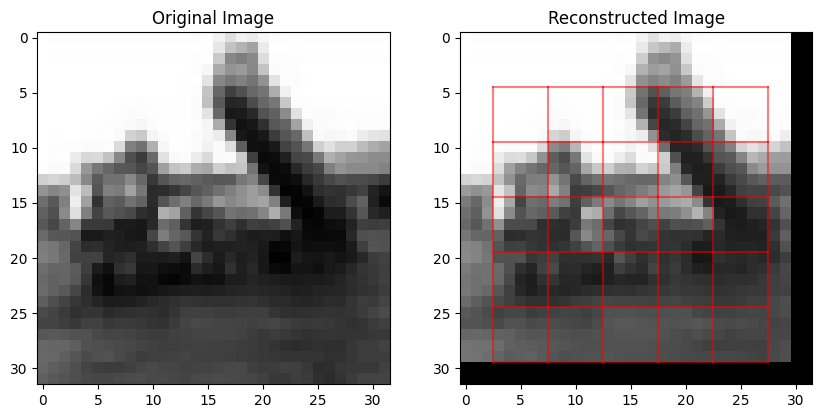

In [63]:
def plot_graph(graph, image):
    h, w = image.shape
    h_patches = h // 5
    w_patches = w // 5

    # Prepare an empty array to hold the reconstructed image
    reconstructed = np.zeros_like(image)

    # Fill the reconstructed image with patches from the nodes
    for idx, node in enumerate(graph.x):
        i = idx // w_patches
        j = idx % w_patches
        reconstructed[i*5:(i+1)*5, j*5:(j+1)*5] = node.reshape(5, 5)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image, cmap='gray') # Display original image
    axs[0].set_title('Original Image')

    axs[1].imshow(reconstructed, cmap='gray') # Display reconstructed image
    axs[1].set_title('Reconstructed Image')

    # Create a dictionary of positions for each node
    positions = {i: ((i % w_patches)*5+2.5, (i // w_patches)*5+2.5) for i in range(h_patches * w_patches)}

    # Draw edges
    for edge in graph.edge_index.t().tolist():
        start = positions[edge[0]]
        end = positions[edge[1]]
        axs[1].plot([start[0], end[0]], [h - start[1], h - end[1]], 'r-', alpha=0.5)  # Draw edge in red

    plt.show()

# Then, you can call this function like so:
plot_graph(graph, image)
